**TASK 1 & 2**

C:\Users\aniru\AppData\Local\Temp\ipykernel_9456\2628128602.py:63: RuntimeWarning: invalid value encountered in sqrt
  results_df.at[results_df.index[k], 'sigma_k_bid'] = np.sqrt(sigma_k_bid_squared)
C:\Users\aniru\AppData\Local\Temp\ipykernel_9456\2628128602.py:69: RuntimeWarning: invalid value encountered in sqrt
  results_df.at[results_df.index[k], 'sigma_k_ask'] = np.sqrt(sigma_k_ask_squared)


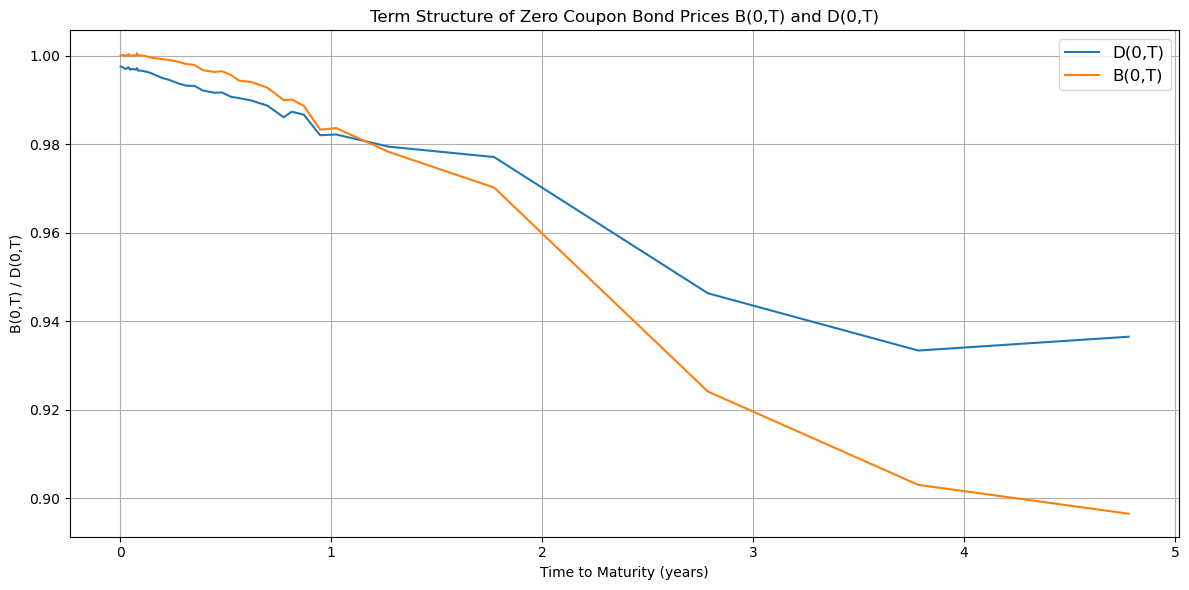

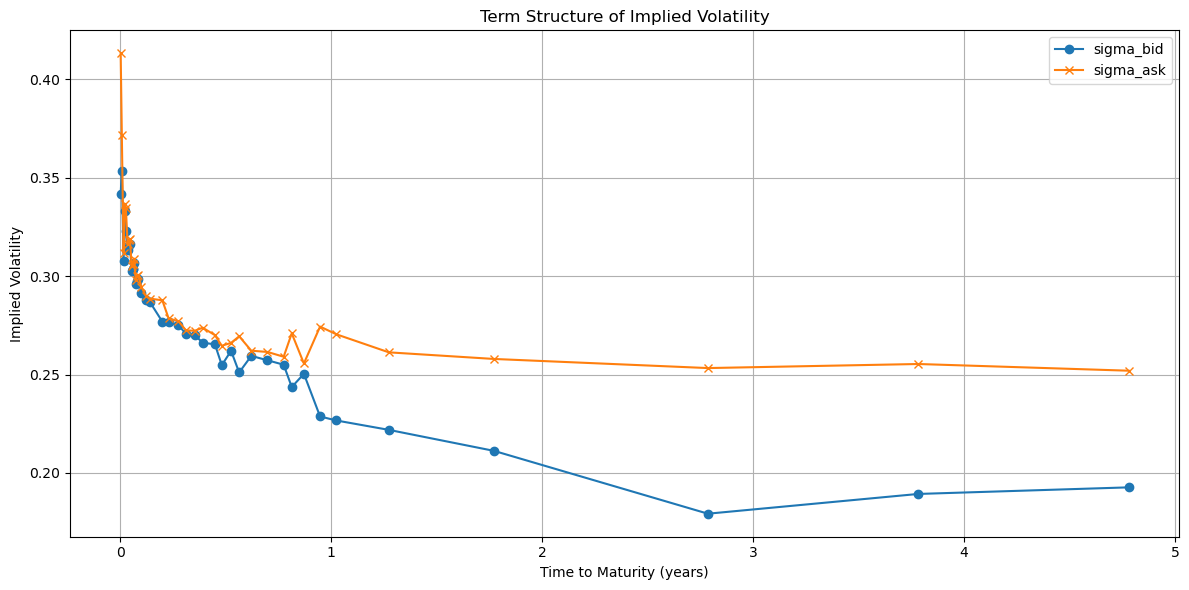

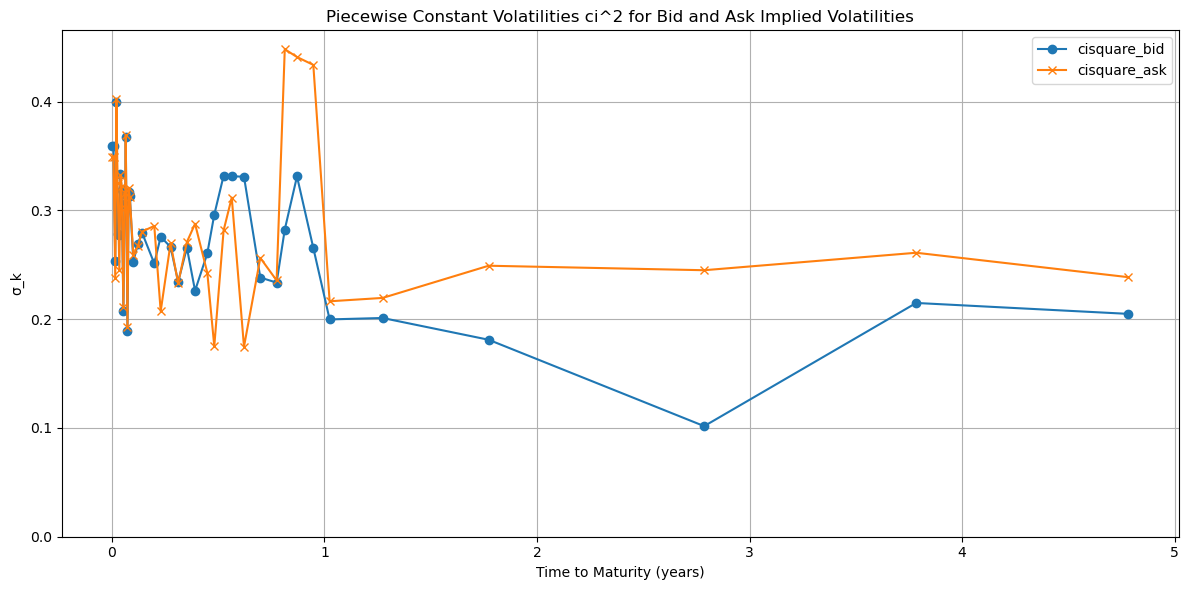

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize, root_scalar
from scipy.stats import norm
from datetime import datetime
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
# Constants
S0 = 4170.7002  # Initial index level
T0 = datetime(2022, 3, 8)  # T0 is March 8, 2022
file_path = "spx_quotedata20220308_all.xlsx"

# Helper functions
def objective(x, K, C, P, S0):
    B, D = x
    return np.sum((C - P - D * S0 + B * K) ** 2)


def black_scholes(S, K, sigma, B, D, T, option_type):
    d1 = (np.log(S * D / (K * B)) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        return S * D * norm.cdf(d1) - K * B * norm.cdf(d2)
    else:
        return K * B * norm.cdf(-d2) - S * D * norm.cdf(-d1)


def black_scholes_imp_vol(S0, K, B, D, T, option_type, market_price):
    def objective_function(sigma):
        model_price = black_scholes(S0, K, sigma, B, D, T, option_type)
        return model_price - market_price

    sol = root_scalar(objective_function, bracket=[0.00001, 5], method='brentq')
    return sol.root


# Load and prepare data
def load_data(file_path):
    df = pd.read_excel(file_path)
    df['Call_Mid'] = (df['Bid'] + df['Ask']) / 2
    df['Put_Mid'] = (df['Bid.1'] + df['Ask.1']) / 2
    return df


# Function to calculate piecewise constant volatilities for both bid and ask implied volatilities
def calculate_piecewise_volatilities(results_df):
    results_df['sigma_k_bid'] = np.nan
    results_df['sigma_k_ask'] = np.nan
    T_values = results_df['T (years)'].values
    sigma_bid_values = results_df['sigma_bid'].values
    sigma_ask_values = results_df['sigma_ask'].values

    for k in range(1, len(T_values)):
        T_k = T_values[k]
        T_k_minus_1 = T_values[k - 1]

        # Calculate sigma_k for bid implied volatilities
        sigma_imp_bid_Tk = sigma_bid_values[k]
        sigma_imp_bid_Tk_minus_1 = sigma_bid_values[k - 1]
        sigma_k_bid_squared = (T_k * sigma_imp_bid_Tk ** 2 - T_k_minus_1 * sigma_imp_bid_Tk_minus_1 ** 2) / (T_k - T_k_minus_1)
        results_df.at[results_df.index[k], 'sigma_k_bid'] = np.sqrt(sigma_k_bid_squared)

        # Calculate sigma_k for ask implied volatilities
        sigma_imp_ask_Tk = sigma_ask_values[k]
        sigma_imp_ask_Tk_minus_1 = sigma_ask_values[k - 1]
        sigma_k_ask_squared = (T_k * sigma_imp_ask_Tk ** 2 - T_k_minus_1 * sigma_imp_ask_Tk_minus_1 ** 2) / (T_k - T_k_minus_1)
        results_df.at[results_df.index[k], 'sigma_k_ask'] = np.sqrt(sigma_k_ask_squared)


    return results_df

def interpolate_ci_values(results_df):
    # Create a copy of the dataframe
    df = results_df.copy()

    df = df.sort_index()

    # List of columns to interpolate
    columns_to_interpolate = ['sigma_k_bid', 'sigma_k_ask']

    for column in columns_to_interpolate:
        # Check if there are any NaN values in the column
        if df[column].isnull().any():
            # Perform linear interpolation
            df[column] = df[column].interpolate(method='linear')

            # If there are still NaN values at the beginning or end, use forward and backward fill
            df[column] = df[column].ffill().bfill()

    return df

def calculate_year_fraction(start_date, end_date):
    # Calculate the total number of days
    delta = end_date - start_date
    total_days = delta.days

    # Count leap days
    leap_days = 0
    for year in range(start_date.year, end_date.year + 1):
        if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0):
            leap_date = datetime(year, 2, 29)
            if start_date < leap_date < end_date:
                leap_days += 1

    # Calculate the fraction of a year
    years = relativedelta(end_date, start_date).years
    remaining_days = total_days - (years * 365 + leap_days)

    return years + remaining_days / 365.0
# Main analysis function
def analyze_options_data(df):
    results_list = []

    for date_str in df['Expiration Date'].unique():
        data = df[df['Expiration Date'] == date_str]
        expiry_date = pd.to_datetime(date_str)
        # T = (expiry_date - T0).days / 365
        T = calculate_year_fraction(T0, expiry_date)

        # Optimize for B and D
        x0 = [1, 1]  # Initial guess for B and D
        res = minimize(objective, x0, args=(data['Strike'], data['Call_Mid'], data['Put_Mid'], S0),
                       method='BFGS', options={'gtol': 1e-8, 'disp': False})
        B, D = res.x

        # Calculate forward price and find closest strike
        forward_price = S0 * D / B
        closest_strike = data.loc[(data['Strike'] - forward_price).abs().idxmin(), 'Strike']

        # Calculate implied volatilities
        call_bid = data.loc[data['Strike'] == closest_strike, 'Bid'].values[0]
        call_ask = data.loc[data['Strike'] == closest_strike, 'Ask'].values[0]
        call_mid = data.loc[data['Strike'] == closest_strike, 'Call_Mid'].values[0]
        IV = data.loc[data['Strike'] == closest_strike, 'IV'].values[0]
        sigma_bid = black_scholes_imp_vol(S0, closest_strike, B, D, T, 'call', call_bid)
        sigma_ask = black_scholes_imp_vol(S0, closest_strike, B, D, T, 'call', call_ask)
        sigma_mid = black_scholes_imp_vol(S0, closest_strike, B, D, T, 'call', call_mid)

        results_list.append({
            'Expiration Date': expiry_date,
            'T (years)': T,
            'B(0,T)': B,
            'D(0,T)': D,
            'Forward Price': forward_price,
            'Closest Strike': closest_strike,
            'sigma_bid': sigma_bid,
            'sigma_ask': sigma_ask,
            'sigma_mid': sigma_mid,
            'IV': IV
        })

    results_df = pd.DataFrame(results_list).set_index('Expiration Date').sort_index()

    # Calculate piecewise constant volatilities
    results_df = calculate_piecewise_volatilities(results_df)
    results_df = interpolate_ci_values(results_df)

    return results_df


# Plotting functions
def plot_B_D(results_df):
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['T (years)'], results_df['D(0,T)'], label='D(0,T)')
    plt.plot(results_df['T (years)'], results_df['B(0,T)'], label='B(0,T)')
    plt.title('Term Structure of Zero Coupon Bond Prices B(0,T) and D(0,T)')
    plt.xlabel('Time to Maturity (years)')
    plt.ylabel('B(0,T) / D(0,T)')
    plt.grid(True)
    plt.legend(loc='best', fontsize=12)
    plt.tight_layout()
    plt.show()


def plot_implied_volatility(results_df):
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['T (years)'], results_df['sigma_bid'], marker='o', label='sigma_bid')
    plt.plot(results_df['T (years)'], results_df['sigma_ask'], marker='x', label='sigma_ask')
    plt.title('Term Structure of Implied Volatility')
    plt.xlabel('Time to Maturity (years)')
    plt.ylabel('Implied Volatility')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_piecewise_volatilities(results_df):
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['T (years)'], results_df['sigma_k_bid'], marker='o', label='cisquare_bid')
    plt.plot(results_df['T (years)'], results_df['sigma_k_ask'], marker='x', label='cisquare_ask')
    plt.title('Piecewise Constant Volatilities ci^2 for Bid and Ask Implied Volatilities')
    plt.xlabel('Time to Maturity (years)')
    plt.ylabel('σ_k')
    plt.legend()
    plt.grid(True)
    plt.yticks(np.arange(0, max(results_df['sigma_k_ask'].max(), results_df['sigma_k_bid'].max()), 0.10))
    plt.tight_layout()
    plt.show()



df = load_data(file_path)
results_df = analyze_options_data(df)
pd.set_option('display.max_columns', None)

#Plotting the results
plot_B_D(results_df)
plot_implied_volatility(results_df)
plot_piecewise_volatilities(results_df)


**TASK 4**

The value of g that solves the equation for alpha = 0.25 is: -0.021018920275449406
The value of g that solves the equation for alpha = 0.5 is: 0.005069866812825114
The value of g that solves the equation for alpha = 0.75 is: 0.019665808756302038


C:\Users\aniru\AppData\Local\Temp\ipykernel_9456\1344552171.py:30: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(B0T / D0T) + (g * T / (1 - alpha)) + 0.5 * ci2_delta_t) / np.sqrt(ci2_delta_t)
C:\Users\aniru\AppData\Local\Temp\ipykernel_9456\1344552171.py:31: RuntimeWarning: divide by zero encountered in divide
  d2 = (-np.log(B0T / D0T) - (g * T / (1 - alpha)) + (0.5 - alpha) * ci2_delta_t) / np.sqrt(ci2_delta_t)


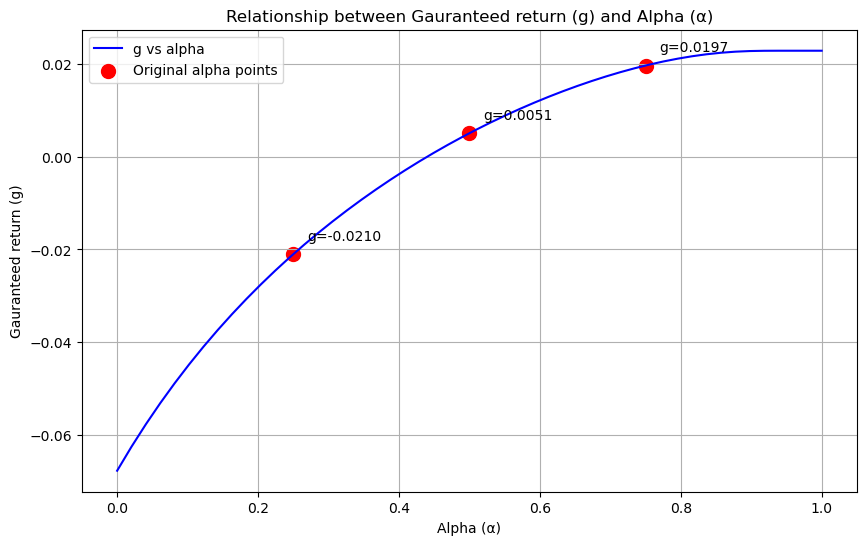

In [3]:
#Alternate approach_Anirudh
import numpy as np
from scipy.stats import norm
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
# Given constant values
S0 = 4170.7002  # S&P index level

# Extracting the last row values for T, B(0,T), D(0,T), and sigma_ask
T = results_df['T (years)'].values[-1]
B0T = results_df['B(0,T)'].values[-1]
D0T = results_df['D(0,T)'].values[-1]
sigma_k_ask = results_df['sigma_k_ask'].values
delta_T = results_df['T (years)'].values
sigma_Ask_T = results_df['sigma_ask'].values[-1]
sigma_ask = results_df['sigma_ask'].values


# Function to solve for g for a given alpha
def option_value(g, alpha):
    # Calculating ci^2 * delta_t which is T * sigma_ask^2
    # ti_offset = np.insert(delta_T[:-1], 0, 0)
    # sigma_ask_offset = np.insert(sigma_ask[:-1],0,0)
    #ci2_delta_t = sum((delta_T - ti_offset) * sigma_k_ask ** 2)#Approach one
    ci2_delta_t = T * sigma_Ask_T ** 2# Approach two
    #ci2_delta_t = np.sum((delta_T * sigma_ask ** 2 - ti_offset * sigma_ask_offset ** 2)) #Approach 3


    # Calculating d1 and d2 based on the given formulas
    d1 = (np.log(B0T / D0T) + (g * T / (1 - alpha)) + 0.5 * ci2_delta_t) / np.sqrt(ci2_delta_t)
    d2 = (-np.log(B0T / D0T) - (g * T / (1 - alpha)) + (0.5 - alpha) * ci2_delta_t) / np.sqrt(ci2_delta_t)

    # Using the option pricing formula to calculate V(0)
    term1 = S0 * np.exp(g * T) * norm.cdf(d1)
    term2 = S0 * (D0T ** (1 - alpha)) / (B0T ** (1 - alpha)) * np.exp(
        0.5 * (alpha ** 2 - alpha) * ci2_delta_t) * norm.cdf(d2)
    V0 = B0T * (term1 + term2)

    # The equation we're solving is V0 = S0
    return V0 - S0


# Loop through the different values of alpha
alphas = [0.25, 0.5, 0.75]
g_initial_guess = 0.05  # A reasonable initial guess for g

for alpha in alphas:
    # Solve for g for each alpha
    g_solution = fsolve(option_value, g_initial_guess, args=(alpha))

    # Output the result for each alpha
    print(f"The value of g that solves the equation for alpha = {alpha} is: {g_solution[0]}")


# Create a range of alpha values
alpha_values = np.linspace(0.0, 1, 50)  # 50 points between 0.1 and 0.9
g_values = []
g_initial_guess = 0.05

# Calculate g for each alpha
for alpha in alpha_values:
    try:
        g_solution = fsolve(option_value, g_initial_guess, args=(alpha))
        g_values.append(g_solution[0])
    except:
        g_values.append(np.nan)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, g_values, 'b-', label='g vs alpha')
plt.scatter([0.25, 0.5, 0.75], [fsolve(option_value, g_initial_guess, args=(a))[0] for a in [0.25, 0.5, 0.75]],
            color='red', s=100, label='Original alpha points')

plt.xlabel('Alpha (α)')
plt.ylabel('Gauranteed return (g)')
plt.title('Relationship between Gauranteed return (g) and Alpha (α)')
plt.grid(True)
plt.legend()

# Add value annotations for the original alpha points
for alpha in [0.25, 0.5, 0.75]:
    g = fsolve(option_value, g_initial_guess, args=(alpha))[0]
    plt.annotate(f'g={g:.4f}',
                xy=(alpha, g),
                xytext=(10, 10),
                textcoords='offset points')

plt.show()

**TASK 5**


Running for alpha=0.25, g=-0.021018920275449406

Running for alpha=0.5, g=0.005069866812825114

Running for alpha=0.75, g=0.019665808756302038


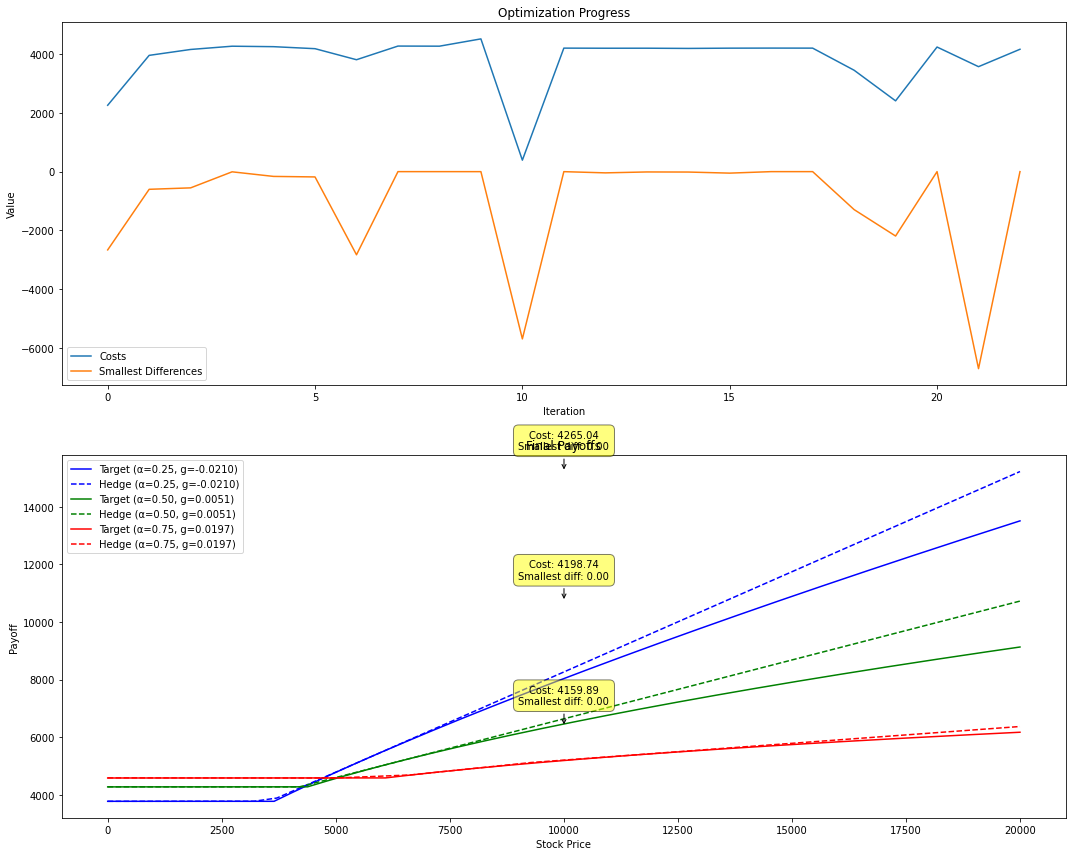


Results for α=0.25, g=-0.0210:
Final cost: 4265.04
Smallest difference: 0.00

Results for α=0.50, g=0.0051:
Final cost: 4198.74
Smallest difference: 0.00

Results for α=0.75, g=0.0197:
Final cost: 4159.89
Smallest difference: 0.00


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import basinhopping

# pairs of alpha and g from Task 4
alpha_g_pairs = [
    (0.25, -0.021018920275449406, 4266),
    (0.5, 0.005069866812825114, 4199),
    (0.75, 0.019665808756302038, 4160)
]
BT = 0.896494# From Task 1

# Vectorized target payoff function
def target_payoff(S, S0, g, T, alpha):
    return np.maximum(S0 * np.exp(g * T), S0 ** alpha * S ** (1 - alpha))


# Options data
options = pd.DataFrame([
    {"type": "cash", "ask": BT, "bid": BT, "strike": None},
    {"strike": 2400, "ask": 2033.1, "bid": 1841.1, "type": "call"},
    {"strike": 3200, "ask": 1479.3, "bid": 1287.3, "type": "call"},
    {"strike": 3700, "ask": 1174.6, "bid": 982.6, "type": "call"},
    {"strike": 4000, "ask": 1007.8, "bid": 815.8, "type": "call"},
    {"strike": 4200, "ask": 904.5, "bid": 712.5, "type": "call"},
    {"strike": 5000, "ask": 554.2, "bid": 362.2, "type": "call"},
    {"strike": 6600, "ask": 160.8, "bid": 80.8, "type": "call"},
    {"strike": 7200, "ask": 114.3, "bid": 34.3, "type": "call"},
    {"strike": 8000, "ask": 300.0, "bid": 0.0, "type": "call"},
    {"strike": 8600, "ask": 300.0, "bid": 0.0, "type": "call"},
    {"strike": 9000, "ask": 300.0, "bid": 0.0, "type": "call"},
    {"strike": 9200, "ask": 288.0, "bid": 5.0, "type": "call"},
    {"strike": 2400, "ask": 252.9, "bid": 125.0, "type": "put"},
    {"strike": 3200, "ask": 411.6, "bid": 219.6, "type": "put"},
    {"strike": 3700, "ask": 568.7, "bid": 376.7, "type": "put"},
    {"strike": 4000, "ask": 671.9, "bid": 479.9, "type": "put"},
    {"strike": 4200, "ask": 752.7, "bid": 560.7, "type": "put"},
    {"strike": 5000, "ask": 1155.4, "bid": 963.4, "type": "put"},
    {"strike": 6600, "ask": 2293.6, "bid": 2101.6, "type": "put"},
    {"strike": 7200, "ask": 2794.4, "bid": 2602.4, "type": "put"},
    {"strike": 8000, "ask": 3491.5, "bid": 3299.5, "type": "put"},
    {"strike": 8600, "ask": 4024.4, "bid": 3832.4, "type": "put"},
    {"strike": 9000, "ask": 4382.1, "bid": 4190.1, "type": "put"},
    {"strike": 9200, "ask": 4561.5, "bid": 4369.5, "type": "put"}
])


# Vectorized option payoff function
def option_payoff(row, S):
    option_type = row['type']
    strike = row['strike']

    if option_type == "stock":
        return S - strike
    elif option_type == "cash":
        return np.ones_like(S)
    elif option_type == "call":
        return np.maximum(S - strike, 0)
    return np.maximum(strike - S, 0)  # put case

def payoff_constrant(weights, args):
    option_payoffs, payoffs, buy_price, sell_price = args
    return np.min(weights @ option_payoffs - payoffs)

def calc_cost(weights, args):
    options_payoff, payoffs, buy_price, sell_price = args
    prices = np.where(weights > 0, buy_price, 0) - np.where(weights < 0, sell_price, 0)

    adjustment = min(payoff_constrant(weights, args), 0)
    return sum(prices * weights)

def no_sell(weights):
    return min(0, weights[9], weights[10], weights[11])

# Lists to store results
all_costs = []
all_smallest_diffs = []
final_results = []

# Parameters
S0 = 4170.70#Given
T = 4.780822#From Task 1
S_Ts = np.linspace(0, 20000, 3000)

for alpha, g, termination in alpha_g_pairs:
    print(f"\nRunning for alpha={alpha}, g={g}")

    # Calculate payoffs for this combination
    payoffs = target_payoff(S_Ts, S0, g, T, alpha)

    # Calculate option payoffs
    option_payoffs = options.apply(option_payoff, axis=1, args=[S_Ts], result_type='expand').to_numpy()

    # Initial values
    weights = np.ones(25)
    weights[12:] = -1

    buy_price = options['ask']
    sell_price = options['bid']

    args = [option_payoffs, payoffs, buy_price, sell_price]
    constraints = [{'type': 'ineq', 'fun': payoff_constrant, 'args': [args]}]

    bounds = [(None, None)] * 25
    bounds[9] = (0, None)
    bounds[10] = (0, None)
    bounds[11] = (0, None)

    costs_history = []

    while True:
        minimizer_kwargs = {
            'method': 'SLSQP',
            'constraints': constraints,
            'bounds': bounds,
            'args': args
        }

        results = basinhopping(calc_cost, x0=weights, minimizer_kwargs=minimizer_kwargs, niter=50)
        weights = results['x']
        cost = results['fun']
        lowest_payoff = payoff_constrant(weights, args)

        costs_history.append((cost, lowest_payoff))

        # print(f"costs: {cost}, smallest: {lowest_payoff}, net: {cost - lowest_payoff}")
        # print(results['lowest_optimization_result']['success'])


        weights[0] = weights[0] - payoff_constrant(weights, args)

        # if (cost - lowest_payoff < 4170):

        # if results['lowest_optimization_result']['success'] == True:
        if (cost - lowest_payoff < termination):
            final_results.append({
                'alpha': alpha,
                'g': g,
                'final_cost': cost,
                'smallest_diff': payoff_constrant(weights, args),
                'weights': weights,
                'payoffs': payoffs,
                'position_payoff': weights @ option_payoffs
            })
            break

    all_costs.extend(costs_history)

# Create plots
plt.figure(figsize=(15, 12))

# Plot 1: Costs vs Iterations
plt.subplot(2, 1, 1)
costs = [x[0] for x in all_costs]
smallest_diffs = [x[1] for x in all_costs]
plt.plot(costs, label='Costs')
plt.plot(smallest_diffs, label='Smallest Differences')
plt.title('Optimization Progress')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()

# Plot 2: Final Payoffs for each alpha-g pair with annotations
plt.subplot(2, 1, 2)
colors = ['b', 'g', 'r']  # Different colors for each alpha-g pair
for idx, result in enumerate(final_results):
    target_line = plt.plot(S_Ts, result['payoffs'],
                           colors[idx],
                           label=f'Target (α={result["alpha"]:.2f}, g={result["g"]:.4f})')
    hedge_line = plt.plot(S_Ts, result['position_payoff'],
                          colors[idx] + '--',  # dashed line
                          label=f'Hedge (α={result["alpha"]:.2f}, g={result["g"]:.4f})')

    x_pos = S_Ts[len(S_Ts) // 2]
    y_pos = max(max(result['payoffs']), max(result['position_payoff']))
    plt.annotate(f'Cost: {result["final_cost"]:.2f}\nSmallest diff: {result["smallest_diff"]:.2f}',
                 xy=(x_pos, y_pos),
                 xytext=(0, 20),
                 textcoords='offset points',
                 ha='center',
                 va='bottom',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.title('Final Payoffs')
plt.xlabel('Stock Price')
plt.ylabel('Payoff')
plt.legend()

plt.tight_layout()
plt.show()

# Print final results
for result in final_results:
    print(f"\nResults for α={result['alpha']:.2f}, g={result['g']:.4f}:")
    print(f"Final cost: {result['final_cost']:.2f}")
    print(f"Smallest difference: {result['smallest_diff']:.2f}")